In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
cv2.__version__

'4.8.0'

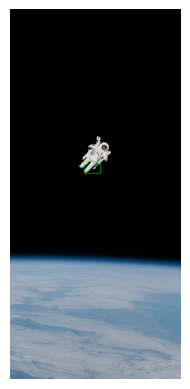

In [3]:
# Load the image
image = cv2.imread('img.jpg')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Edge detection
edges = cv2.Canny(gray, 30, 100)

# Find contours
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour
largest_contour = max(contours, key=cv2.contourArea)

# Get the bounding rectangle
x, y, w, h = cv2.boundingRect(largest_contour)

image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Crop the image
cropped_image = image[y:y+h, x:x+w]

# Save or display the cropped image
# cv2.imwrite('cropped_image.jpg', cropped_image)
# cv2.imshow('Cropped Image', cropped_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')  # Hide axis
plt.show()


(700, 725, 3)


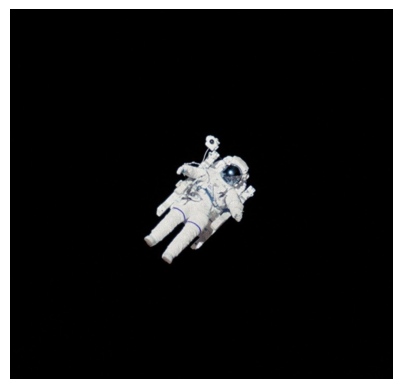

In [4]:
# load image and crop it to only one object in the middle
image = cv2.imread('img.jpg')
img_new = image[600:1300, 200:-200, :]
print(img_new.shape)
cv2.imwrite('img_crop.jpg', img_new)
plt.imshow(img_new)
plt.axis('off')
plt.show()

(700, 725)


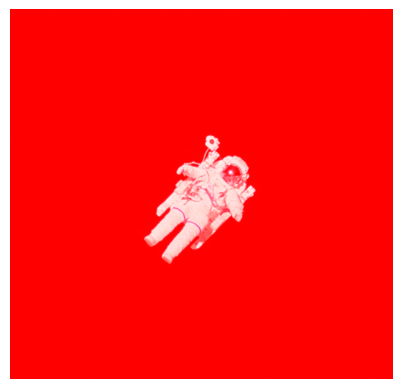

In [5]:
# Convert to grayscale
gray = cv2.cvtColor(img_new, cv2.COLOR_BGR2GRAY)

# Edge detection
edges = cv2.Canny(gray, 30, 100)
print(edges.shape)
edges_bgr = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
edges_bgr[:, :, 0] = 255  # Set blue channel to 0
edges_bgr[:, :, 1] = 0  # Set green channel to 0
edges_bgr[:, :, 2] = 0  # Set red channel to 255
# Draw the edges on the original image
result = cv2.addWeighted(img_new, 1, edges_bgr, 1, 0)
plt.imshow(result)
plt.axis('off')
plt.show()

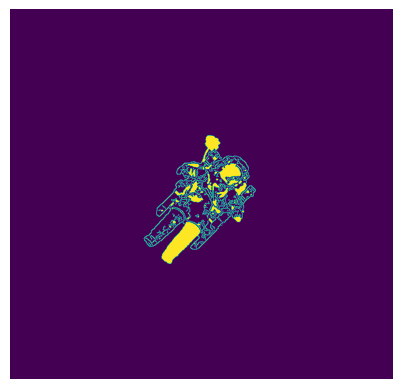

In [6]:
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# for c in contours:
#     print(c.shape)

min_x = float('inf')
max_x = float('-inf')
min_y = float('inf')
max_y = float('-inf')

for contour in contours:
    for point in contour:
        x, y = point[0]
        min_x = min(min_x, x)
        max_x = max(max_x, x)
        min_y = min(min_y, y)
        max_y = max(max_y, y)

contour_image = np.zeros_like(edges)

# Draw contours on the blank image
contour_image = cv2.drawContours(contour_image, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

# Display the contour image
plt.imshow(contour_image)
plt.axis('off')
plt.show()

(-0.5, 724.5, 699.5, -0.5)

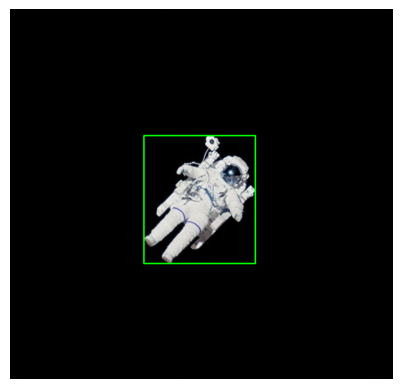

In [7]:
img_new_crop = cv2.rectangle(img_new, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)
plt.imshow(img_new_crop)
plt.axis('off')

In [8]:
def draw_edge(image_path, lo_thresh=30, up_thresh=100):
    # Convert to grayscale
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Edge detection
    edges = cv2.Canny(gray, lo_thresh, up_thresh)
    
    edges_bgr = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    # edges_bgr[:, :, 0] = 255
    # edges_bgr[:, :, 1] = 0
    # edges_bgr[:, :, 2] = 0
    # Draw the edges on the original image
    # result = cv2.addWeighted(image, 1, edges_bgr, 1, 0)
    
    blank_image = np.zeros_like(image)
    
    # Draw the edges on the blank image
    edges_bgr = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    result = cv2.addWeighted(blank_image, 1, edges_bgr, 1, 0)
    
    plt.imshow(result)
    plt.axis('off')

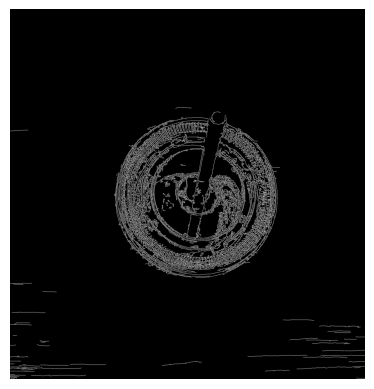

In [9]:
draw_edge('test1.jpg', lo_thresh=30, up_thresh=100)

In [10]:
def clip_to_boundary(bbox, h, w):
    
    x_min = max(bbox[0], 0)
    y_min = max(bbox[1], 0)
    x_max = min(bbox[2], w)
    y_max = min(bbox[3], h)
    
    return x_min, y_min, x_max, y_max
    

def crop_obj(image_path, padding=10, lo_thresh=30, up_thresh=150, if_maxmin=True):
    """
    Crop out the object in a simple background.
    Input:
    - image_path, str
    - padding, int, padding pixels of crop bounding box
    - lo_thresh, int, lower threshold for Canny
    - up_thresh, int, upper threshold for Canny
    - if_maxmin, bool, if use the min and max of xs and ys.
    """
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, lo_thresh, up_thresh)
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # calculate contour bbox
    if if_maxmin:
        x_min = w
        x_max = 0
        y_min = h
        y_max = 0
        for contour in contours:
            for point in contour:
                x, y = point[0]
                x_min = min(x_min, x)
                x_max = max(x_max, x)
                y_min = min(y_min, y)
                y_max = max(y_max, y)
    else:   
        largest_contour = max(contours, key=cv2.contourArea)
        x_min, y_min, w, h = cv2.boundingRect(largest_contour)
        x_max = x_min + w
        y_max = y_min + h
        
    # padding to bbox
    x_min -= padding
    y_min -= padding
    x_max += padding
    y_max += padding
    x_min, y_min, x_max, y_max = clip_to_boundary((x_min, y_min, x_max, y_max), h, w)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_new_crop = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    plt.imshow(img_new_crop)
    plt.axis('off')

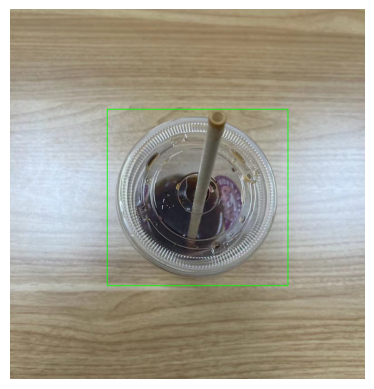

In [11]:
crop_obj('test1.jpg', padding=30, lo_thresh=30, up_thresh=150, if_maxmin=True)